
# Data Exploration

In [95]:
!pip install tensorflow_addons

In [96]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [97]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [98]:
from collections import Counter
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime

# Getting Data (If it is saved earlier)

In [99]:
# from google.colab import drive
# drive.mount('/content/drive')

In [100]:
# IMAGE
RAW_IMG_SIZE = 128
NUM_CLASSES = 268
INPUT_SHAPE = (RAW_IMG_SIZE, RAW_IMG_SIZE, 3)
SPLIT_SEED = 198

# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = RAW_IMG_SIZE
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 70

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [101]:
pathh='C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\Veriler\\cumartesi_hepsivar16\\10\\128'
y_train_aug_le= np.loadtxt(pathh+'/y_train_aug_le.txt', dtype=float)
y_train_aug_cat= np.loadtxt(pathh+'/y_train_aug_cat.txt', dtype=float)
y_val_le= np.loadtxt(pathh+'/y_val_le.txt', dtype=float)
y_val_cat= np.loadtxt(pathh+'/y_val_cat.txt', dtype=float)
y_test_le= np.loadtxt(pathh+'/y_test_le.txt', dtype=float)
y_test_cat= np.loadtxt(pathh+'/y_test_cat.txt', dtype=float)
x_train= np.load(pathh+'/x_train.npy')
x_val= np.load(pathh+'/x_val.npy')
x_test= np.load(pathh+'/x_test.npy')
y_test= np.load(pathh+'/y_test.npy')
y_val= np.load(pathh+'/y_val.npy')
y_train= np.load(pathh+'/y_train.npy')

# **Model**

In [102]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 150
image_size = RAW_IMG_SIZE  # We'll resize input images to this size                   72
patch_size = PATCH_SIZE  # Size of the patches to be extract from the input images   6  optimali 6 
num_patches = (image_size // patch_size) ** 2         
projection_dim = 64                                                       # 64
num_heads = 4                                                             # 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8                                                
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
input_shape = (RAW_IMG_SIZE, RAW_IMG_SIZE, 3)
num_classes = 268

In [103]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        #layers.RandomFlip("horizontal_and_vertical"),
        # layers.RandomRotation(factor=0.02),
        #layers.GaussianNoise(0.3),
        # layers.RandomBrightness(0.002),
        # layers.RandomContrast(0.002)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [104]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [105]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [106]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [107]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [108]:
def run_experiment(model):


    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            tfa.metrics.CohenKappa(num_classes=268, sparse_labels=True)
        ],
    )

    kayit_adresi = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\model_kayitlari_bittik2"
    if not os.path.exists(kayit_adresi):
        os.mkdir(kayit_adresi)

    zaman = datetime.today().strftime('%d-%m-%Y-%H-%M')
    model_kayit_noktasi_adresi = os.path.join(kayit_adresi,zaman)
    os.mkdir(model_kayit_noktasi_adresi)
    
    
    # kayit adresleri
    checkpoint_filepath  = os.path.join(model_kayit_noktasi_adresi,"model")

    # CHECKPOINT
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor='val_accuracy',
    save_best_only = True)

    # LRR
    lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  
    factor=.1,  # Factor by which learning rate will be reduced
    patience=20,
    min_lr=1e-5)

    callbacks = [ checkpoint_callback, lrr]

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=EPOCHS,
        validation_data=(x_val,y_val),
        callbacks=callbacks
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy, kappa_score= model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    # print(f"Kappa Score:{kappa_score}")

    # txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"agumentasyon_modeli.txt")
    # try:
    #     with open(txt_kayit_adresi, "w") as fh:
    #         fh.write(f"Vanilla: {vanilla}\nEpok sayisi: {EPOCHS}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}%\nCohenKappa Skoru: {kappa_score}\nResim Boyutu: {IMAGE_SIZE}\nPatch Boyutu: {PATCH_SIZE}\nTest top 5 accuracy: {round(top_5_accuracy * 100, 2)}%\n loss='categorical_crossentropy' metrics=['accuracy']\n{pathh}\n")
    #         data_augmentation.summary(print_fn=lambda x: fh.write(x + '\n'))

    # except Exception as e2:
    #     print("Model txt ye yazdirilamadi, hata: ", e2)


    return history, model_kayit_noktasi_adresi, model, checkpoint_filepath




# Run experiments with the vanilla ViT
vit_classifier = create_vit_classifier()
history, model_kayit_noktasi_adresi, model, checkpoint_filepath  = run_experiment(vit_classifier)

Epoch 1/70
145/146 [============================>.] - ETA: 0s - loss: 4.8739 - accuracy: 0.0654 - top-5-accuracy: 0.1976 - cohen_kappa: 0.0503

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 17s 84ms/step - loss: 4.8719 - accuracy: 0.0654 - top-5-accuracy: 0.1979 - cohen_kappa: 0.0504 - val_loss: 4.2834 - val_accuracy: 0.1225 - val_top-5-accuracy: 0.3020 - val_cohen_kappa: 0.1151 - lr: 0.0010
Epoch 2/70
145/146 [============================>.] - ETA: 0s - loss: 3.8685 - accuracy: 0.1357 - top-5-accuracy: 0.3720 - cohen_kappa: 0.1235

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 79ms/step - loss: 3.8689 - accuracy: 0.1356 - top-5-accuracy: 0.3720 - cohen_kappa: 0.1235 - val_loss: 3.2723 - val_accuracy: 0.2251 - val_top-5-accuracy: 0.4843 - val_cohen_kappa: 0.2199 - lr: 0.0010
Epoch 3/70
145/146 [============================>.] - ETA: 0s - loss: 3.2862 - accuracy: 0.2051 - top-5-accuracy: 0.4854 - cohen_kappa: 0.1951

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 80ms/step - loss: 3.2845 - accuracy: 0.2053 - top-5-accuracy: 0.4856 - cohen_kappa: 0.1954 - val_loss: 2.8256 - val_accuracy: 0.3020 - val_top-5-accuracy: 0.5926 - val_cohen_kappa: 0.2978 - lr: 0.0010
Epoch 4/70
145/146 [============================>.] - ETA: 0s - loss: 2.9137 - accuracy: 0.2590 - top-5-accuracy: 0.5598 - cohen_kappa: 0.2500

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 80ms/step - loss: 2.9130 - accuracy: 0.2592 - top-5-accuracy: 0.5601 - cohen_kappa: 0.2502 - val_loss: 2.4265 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.6809 - val_cohen_kappa: 0.3296 - lr: 0.0010
Epoch 5/70
145/146 [============================>.] - ETA: 0s - loss: 2.6283 - accuracy: 0.3166 - top-5-accuracy: 0.6272 - cohen_kappa: 0.3085

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 78ms/step - loss: 2.6277 - accuracy: 0.3167 - top-5-accuracy: 0.6271 - cohen_kappa: 0.3086 - val_loss: 2.0889 - val_accuracy: 0.4217 - val_top-5-accuracy: 0.7379 - val_cohen_kappa: 0.4185 - lr: 0.0010
Epoch 6/70
145/146 [============================>.] - ETA: 0s - loss: 2.3869 - accuracy: 0.3636 - top-5-accuracy: 0.6805 - cohen_kappa: 0.3561

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 78ms/step - loss: 2.3864 - accuracy: 0.3636 - top-5-accuracy: 0.6807 - cohen_kappa: 0.3561 - val_loss: 1.9269 - val_accuracy: 0.4729 - val_top-5-accuracy: 0.7692 - val_cohen_kappa: 0.4701 - lr: 0.0010
Epoch 7/70
145/146 [============================>.] - ETA: 0s - loss: 2.1481 - accuracy: 0.4221 - top-5-accuracy: 0.7269 - cohen_kappa: 0.4155

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 78ms/step - loss: 2.1481 - accuracy: 0.4223 - top-5-accuracy: 0.7268 - cohen_kappa: 0.4157 - val_loss: 1.5411 - val_accuracy: 0.5755 - val_top-5-accuracy: 0.8490 - val_cohen_kappa: 0.5731 - lr: 0.0010
Epoch 8/70
145/146 [============================>.] - ETA: 0s - loss: 1.9836 - accuracy: 0.4637 - top-5-accuracy: 0.7576 - cohen_kappa: 0.4577

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 79ms/step - loss: 1.9834 - accuracy: 0.4639 - top-5-accuracy: 0.7577 - cohen_kappa: 0.4579 - val_loss: 1.3846 - val_accuracy: 0.5983 - val_top-5-accuracy: 0.8860 - val_cohen_kappa: 0.5960 - lr: 0.0010
Epoch 9/70
145/146 [============================>.] - ETA: 0s - loss: 1.7990 - accuracy: 0.5031 - top-5-accuracy: 0.7944 - cohen_kappa: 0.4975

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 80ms/step - loss: 1.7993 - accuracy: 0.5032 - top-5-accuracy: 0.7944 - cohen_kappa: 0.4976 - val_loss: 1.2881 - val_accuracy: 0.6268 - val_top-5-accuracy: 0.8946 - val_cohen_kappa: 0.6247 - lr: 0.0010
Epoch 10/70
145/146 [============================>.] - ETA: 0s - loss: 1.6421 - accuracy: 0.5416 - top-5-accuracy: 0.8170 - cohen_kappa: 0.5365

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 1.6410 - accuracy: 0.5417 - top-5-accuracy: 0.8170 - cohen_kappa: 0.5366 - val_loss: 1.1753 - val_accuracy: 0.6952 - val_top-5-accuracy: 0.9117 - val_cohen_kappa: 0.6935 - lr: 0.0010
Epoch 11/70
145/146 [============================>.] - ETA: 0s - loss: 1.5344 - accuracy: 0.5707 - top-5-accuracy: 0.8406 - cohen_kappa: 0.5660

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 1.5348 - accuracy: 0.5704 - top-5-accuracy: 0.8406 - cohen_kappa: 0.5656 - val_loss: 1.0987 - val_accuracy: 0.7094 - val_top-5-accuracy: 0.9259 - val_cohen_kappa: 0.7079 - lr: 0.0010
Epoch 12/70
145/146 [============================>.] - ETA: 0s - loss: 1.3904 - accuracy: 0.6101 - top-5-accuracy: 0.8634 - cohen_kappa: 0.6058

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 1.3910 - accuracy: 0.6098 - top-5-accuracy: 0.8633 - cohen_kappa: 0.6055 - val_loss: 1.0414 - val_accuracy: 0.7179 - val_top-5-accuracy: 0.9316 - val_cohen_kappa: 0.7164 - lr: 0.0010
Epoch 13/70
146/146 [==============================] - 5s 34ms/step - loss: 1.3014 - accuracy: 0.6359 - top-5-accuracy: 0.8765 - cohen_kappa: 0.6319 - val_loss: 1.0137 - val_accuracy: 0.7151 - val_top-5-accuracy: 0.9316 - val_cohen_kappa: 0.7136 - lr: 0.0010
Epoch 14/70
145/146 [============================>.] - ETA: 0s - loss: 1.1857 - accuracy: 0.6663 - top-5-accuracy: 0.8898 - cohen_kappa: 0.6626

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 83ms/step - loss: 1.1848 - accuracy: 0.6665 - top-5-accuracy: 0.8899 - cohen_kappa: 0.6628 - val_loss: 0.9871 - val_accuracy: 0.7379 - val_top-5-accuracy: 0.9202 - val_cohen_kappa: 0.7365 - lr: 0.0010
Epoch 15/70
146/146 [==============================] - 5s 34ms/step - loss: 1.1100 - accuracy: 0.6883 - top-5-accuracy: 0.8992 - cohen_kappa: 0.6849 - val_loss: 0.9952 - val_accuracy: 0.7350 - val_top-5-accuracy: 0.9373 - val_cohen_kappa: 0.7336 - lr: 0.0010
Epoch 16/70
145/146 [============================>.] - ETA: 0s - loss: 1.0265 - accuracy: 0.7105 - top-5-accuracy: 0.9095 - cohen_kappa: 0.7073

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 1.0267 - accuracy: 0.7102 - top-5-accuracy: 0.9095 - cohen_kappa: 0.7070 - val_loss: 0.9045 - val_accuracy: 0.7664 - val_top-5-accuracy: 0.9288 - val_cohen_kappa: 0.7651 - lr: 0.0010
Epoch 17/70
146/146 [==============================] - 5s 34ms/step - loss: 0.9196 - accuracy: 0.7429 - top-5-accuracy: 0.9202 - cohen_kappa: 0.7401 - val_loss: 0.8835 - val_accuracy: 0.7493 - val_top-5-accuracy: 0.9345 - val_cohen_kappa: 0.7480 - lr: 0.0010
Epoch 18/70
145/146 [============================>.] - ETA: 0s - loss: 0.8727 - accuracy: 0.7560 - top-5-accuracy: 0.9267 - cohen_kappa: 0.7534

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 0.8742 - accuracy: 0.7559 - top-5-accuracy: 0.9266 - cohen_kappa: 0.7532 - val_loss: 0.8407 - val_accuracy: 0.8091 - val_top-5-accuracy: 0.9459 - val_cohen_kappa: 0.8081 - lr: 0.0010
Epoch 19/70
146/146 [==============================] - 5s 33ms/step - loss: 0.8218 - accuracy: 0.7675 - top-5-accuracy: 0.9323 - cohen_kappa: 0.7650 - val_loss: 0.9083 - val_accuracy: 0.7721 - val_top-5-accuracy: 0.9288 - val_cohen_kappa: 0.7709 - lr: 0.0010
Epoch 20/70
145/146 [============================>.] - ETA: 0s - loss: 0.7712 - accuracy: 0.7812 - top-5-accuracy: 0.9356 - cohen_kappa: 0.7789

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 12s 82ms/step - loss: 0.7728 - accuracy: 0.7810 - top-5-accuracy: 0.9354 - cohen_kappa: 0.7786 - val_loss: 0.8472 - val_accuracy: 0.8148 - val_top-5-accuracy: 0.9459 - val_cohen_kappa: 0.8138 - lr: 0.0010
Epoch 21/70
146/146 [==============================] - 5s 34ms/step - loss: 0.7278 - accuracy: 0.7968 - top-5-accuracy: 0.9407 - cohen_kappa: 0.7946 - val_loss: 0.8681 - val_accuracy: 0.7835 - val_top-5-accuracy: 0.9373 - val_cohen_kappa: 0.7823 - lr: 0.0010
Epoch 22/70
146/146 [==============================] - 5s 34ms/step - loss: 0.6820 - accuracy: 0.8082 - top-5-accuracy: 0.9440 - cohen_kappa: 0.8061 - val_loss: 0.8591 - val_accuracy: 0.8091 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8081 - lr: 0.0010
Epoch 23/70
146/146 [==============================] - 6s 40ms/step - loss: 0.6483 - accuracy: 0.8193 - top-5-accuracy: 0.9472 - cohen_kappa: 0.8174 - val_loss: 0.9347 - val_accuracy: 0.7806 - val_top-5-accuracy: 0.9430 - val_cohen_ka

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 110ms/step - loss: 0.5810 - accuracy: 0.8425 - top-5-accuracy: 0.9515 - cohen_kappa: 0.8408 - val_loss: 0.8383 - val_accuracy: 0.8319 - val_top-5-accuracy: 0.9345 - val_cohen_kappa: 0.8310 - lr: 0.0010
Epoch 26/70
146/146 [==============================] - 9s 62ms/step - loss: 0.5828 - accuracy: 0.8374 - top-5-accuracy: 0.9515 - cohen_kappa: 0.8357 - val_loss: 0.8749 - val_accuracy: 0.8006 - val_top-5-accuracy: 0.9316 - val_cohen_kappa: 0.7995 - lr: 0.0010
Epoch 27/70
146/146 [==============================] - 9s 62ms/step - loss: 0.5455 - accuracy: 0.8512 - top-5-accuracy: 0.9533 - cohen_kappa: 0.8496 - val_loss: 0.8558 - val_accuracy: 0.8148 - val_top-5-accuracy: 0.9345 - val_cohen_kappa: 0.8138 - lr: 0.0010
Epoch 28/70
146/146 [==============================] - 9s 62ms/step - loss: 0.5205 - accuracy: 0.8561 - top-5-accuracy: 0.9553 - cohen_kappa: 0.8545 - val_loss: 0.9289 - val_accuracy: 0.8063 - val_top-5-accuracy: 0.9345 - val_cohen_k

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 111ms/step - loss: 0.4591 - accuracy: 0.8729 - top-5-accuracy: 0.9577 - cohen_kappa: 0.8715 - val_loss: 0.8677 - val_accuracy: 0.8376 - val_top-5-accuracy: 0.9345 - val_cohen_kappa: 0.8367 - lr: 0.0010
Epoch 32/70
146/146 [==============================] - 9s 62ms/step - loss: 0.4591 - accuracy: 0.8715 - top-5-accuracy: 0.9601 - cohen_kappa: 0.8701 - val_loss: 0.9044 - val_accuracy: 0.8177 - val_top-5-accuracy: 0.9345 - val_cohen_kappa: 0.8167 - lr: 0.0010
Epoch 33/70
145/146 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.8753 - top-5-accuracy: 0.9601 - cohen_kappa: 0.8740

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 110ms/step - loss: 0.4457 - accuracy: 0.8755 - top-5-accuracy: 0.9601 - cohen_kappa: 0.8742 - val_loss: 0.8887 - val_accuracy: 0.8405 - val_top-5-accuracy: 0.9402 - val_cohen_kappa: 0.8396 - lr: 0.0010
Epoch 34/70
146/146 [==============================] - 9s 65ms/step - loss: 0.4494 - accuracy: 0.8751 - top-5-accuracy: 0.9591 - cohen_kappa: 0.8738 - val_loss: 0.9310 - val_accuracy: 0.8348 - val_top-5-accuracy: 0.9316 - val_cohen_kappa: 0.8339 - lr: 0.0010
Epoch 35/70
146/146 [==============================] - 9s 64ms/step - loss: 0.4331 - accuracy: 0.8788 - top-5-accuracy: 0.9613 - cohen_kappa: 0.8775 - val_loss: 0.9371 - val_accuracy: 0.8091 - val_top-5-accuracy: 0.9402 - val_cohen_kappa: 0.8081 - lr: 0.0010
Epoch 36/70
146/146 [==============================] - 9s 65ms/step - loss: 0.4146 - accuracy: 0.8820 - top-5-accuracy: 0.9629 - cohen_kappa: 0.8808 - val_loss: 0.9632 - val_accuracy: 0.8291 - val_top-5-accuracy: 0.9174 - val_cohen_k

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 111ms/step - loss: 0.1889 - accuracy: 0.9487 - top-5-accuracy: 0.9812 - cohen_kappa: 0.9482 - val_loss: 0.8434 - val_accuracy: 0.8519 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8511 - lr: 1.0000e-04
Epoch 57/70
146/146 [==============================] - 9s 63ms/step - loss: 0.1908 - accuracy: 0.9484 - top-5-accuracy: 0.9811 - cohen_kappa: 0.9479 - val_loss: 0.8170 - val_accuracy: 0.8519 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8511 - lr: 1.0000e-04
Epoch 58/70
146/146 [==============================] - 9s 62ms/step - loss: 0.1856 - accuracy: 0.9501 - top-5-accuracy: 0.9813 - cohen_kappa: 0.9496 - val_loss: 0.8143 - val_accuracy: 0.8462 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8453 - lr: 1.0000e-04
Epoch 59/70
145/146 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9533 - top-5-accuracy: 0.9823 - cohen_kappa: 0.9528

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 110ms/step - loss: 0.1785 - accuracy: 0.9533 - top-5-accuracy: 0.9824 - cohen_kappa: 0.9528 - val_loss: 0.8024 - val_accuracy: 0.8575 - val_top-5-accuracy: 0.9373 - val_cohen_kappa: 0.8568 - lr: 1.0000e-04
Epoch 60/70
145/146 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9523 - top-5-accuracy: 0.9823 - cohen_kappa: 0.9518

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 109ms/step - loss: 0.1815 - accuracy: 0.9523 - top-5-accuracy: 0.9823 - cohen_kappa: 0.9518 - val_loss: 0.7853 - val_accuracy: 0.8604 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8597 - lr: 1.0000e-04
Epoch 61/70
146/146 [==============================] - 9s 62ms/step - loss: 0.1800 - accuracy: 0.9532 - top-5-accuracy: 0.9819 - cohen_kappa: 0.9527 - val_loss: 0.7838 - val_accuracy: 0.8547 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8539 - lr: 1.0000e-04
Epoch 62/70
146/146 [==============================] - 9s 61ms/step - loss: 0.1813 - accuracy: 0.9536 - top-5-accuracy: 0.9826 - cohen_kappa: 0.9531 - val_loss: 0.7726 - val_accuracy: 0.8575 - val_top-5-accuracy: 0.9430 - val_cohen_kappa: 0.8568 - lr: 1.0000e-04
Epoch 63/70
145/146 [============================>.] - ETA: 0s - loss: 0.1771 - accuracy: 0.9550 - top-5-accuracy: 0.9827 - cohen_kappa: 0.9545

INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\OneDrive\Masaüstü\polen-github\model_kayitlari_bittik2\03-06-2023-23-22\model\assets


146/146 [==============================] - 16s 107ms/step - loss: 0.1773 - accuracy: 0.9548 - top-5-accuracy: 0.9827 - cohen_kappa: 0.9543 - val_loss: 0.7675 - val_accuracy: 0.8632 - val_top-5-accuracy: 0.9459 - val_cohen_kappa: 0.8625 - lr: 1.0000e-04
Epoch 64/70
146/146 [==============================] - 9s 61ms/step - loss: 0.1761 - accuracy: 0.9540 - top-5-accuracy: 0.9836 - cohen_kappa: 0.9535 - val_loss: 0.7633 - val_accuracy: 0.8519 - val_top-5-accuracy: 0.9459 - val_cohen_kappa: 0.8511 - lr: 1.0000e-04
Epoch 65/70
146/146 [==============================] - 9s 61ms/step - loss: 0.1782 - accuracy: 0.9553 - top-5-accuracy: 0.9824 - cohen_kappa: 0.9549 - val_loss: 0.7509 - val_accuracy: 0.8547 - val_top-5-accuracy: 0.9459 - val_cohen_kappa: 0.8539 - lr: 1.0000e-04
Epoch 66/70
146/146 [==============================] - 9s 61ms/step - loss: 0.1769 - accuracy: 0.9553 - top-5-accuracy: 0.9831 - cohen_kappa: 0.9548 - val_loss: 0.7457 - val_accuracy: 0.8490 - val_top-5-accuracy: 0.9430 -

In [109]:
model_2 = tf.keras.models.load_model(checkpoint_filepath, compile=True, custom_objects = {"Patches": Patches, "PatchEncoder": PatchEncoder})
_, accuracy, top_5_accuracy, kappa_score= model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
print(f"Kappa Score:{kappa_score}")



11/11 [==============================] - 0s 27ms/step - loss: 0.8033 - accuracy: 0.8232 - top-5-accuracy: 0.9390 - cohen_kappa: 0.8223
Test accuracy: 82.32%
Test top 5 accuracy: 93.9%
Kappa Score:0.8222786784172058


In [110]:
q = model_2.predict(np.array([x_test[5],] ))
y_classes = q.argmax(axis=-1)
print(y_classes)

1/1 [==============================] - 1s 524ms/step
[5]


In [111]:
model_2.evaluate(x_test,y_test)

11/11 [==============================] - 1s 14ms/step - loss: 0.8561 - accuracy: 0.8293 - top-5-accuracy: 0.9482 - cohen_kappa: 0.8284


[0.8561495542526245,
 0.8292682766914368,
 0.9481707215309143,
 0.8284085988998413]

In [112]:
import numpy as np
from sklearn.metrics import confusion_matrix

#Load the predicted labels and true labels
y_pred = model.predict(x_test)  # Load your predicted labels
y_true = y_test  # Load your true labels

#Create the confusion matrix
cm = confusion_matrix(y_true, y_pred.argmax(axis=-1))

tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

arr_replaced = np.nan_to_num(f1, nan=0)
#Print the F1 score
print("F1 Score:", np.mean(arr_replaced))

11/11 [==============================] - 1s 12ms/step
F1 Score: 0.7502589864530163


C:\Users\PC\AppData\Local\Temp\ipykernel_5060\1454713841.py:15: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\PC\AppData\Local\Temp\ipykernel_5060\1454713841.py:17: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


In [113]:
txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"agumentasyon_modeli.txt")
try:
    with open(txt_kayit_adresi, "w") as fh:
        fh.write(f"Epok sayisi: {EPOCHS}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}%\nCohenKappa Skoru: {kappa_score}\nF1 Skor: {np.mean(arr_replaced)}\nResim Boyutu: {IMAGE_SIZE}\nPatch Boyutu: {PATCH_SIZE}\nTest top 5 accuracy: {round(top_5_accuracy * 100, 2)}%\n{pathh}\n")
        

except Exception as e2:
    print("Model txt ye yazdirilamadi, hata: ", e2)

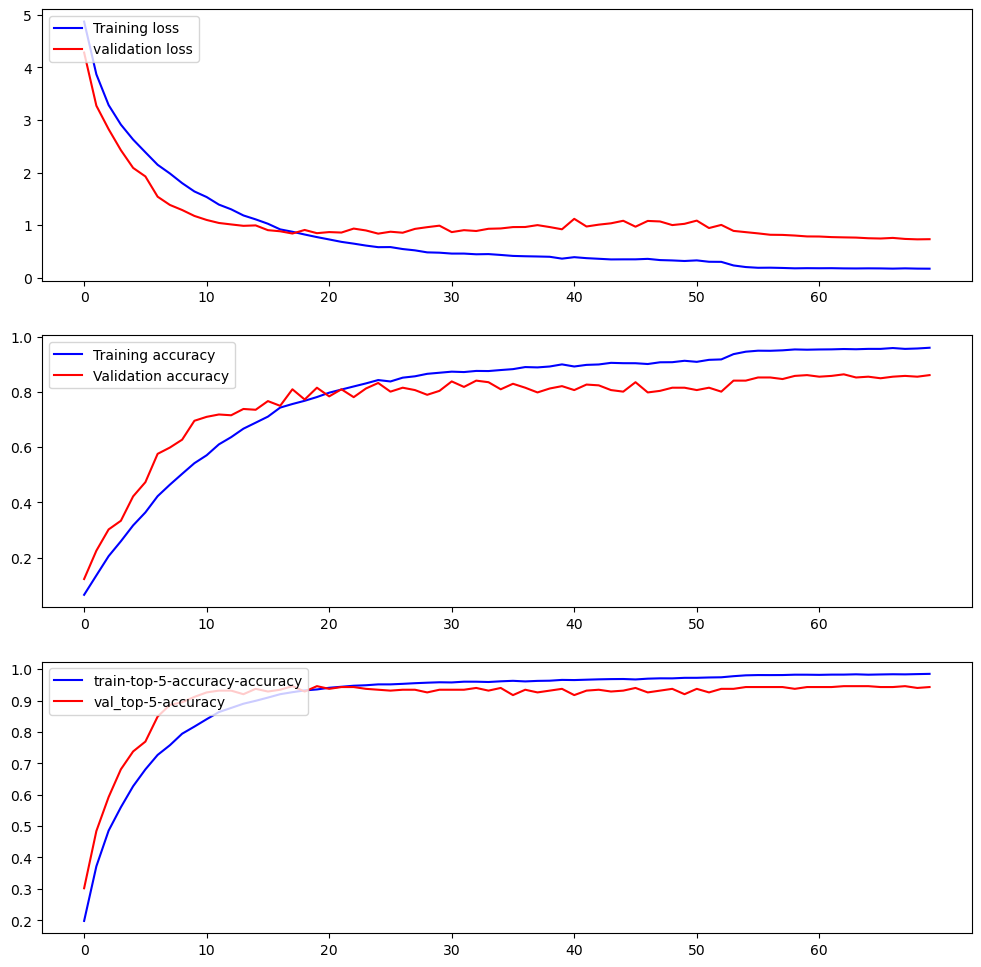

In [114]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "Grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, EPOCHS, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, EPOCHS, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top-5-accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top-5-accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, EPOCHS, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")